In [244]:
import pandas as pd
import numpy as np
from pathlib import Path
from ts.utils.data_utils import download_yahoo_finance_ticker
import plotly.express as px
from ts.utils.plot_utils import decorate_plot, decomposition_plot, plot_autocorrelation
from statsmodels.tsa.seasonal import seasonal_decompose
from ts.utils.data_utils import add_freq
from ts.decomposition.seasonal import STL, FourierDecomposition, MultiSeasonalDecomposition
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from ts.utils.ts_utils import make_stationary
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [156]:
plt.style.use('ggplot')

In [157]:
!curl -o data/energy.csv https://raw.githubusercontent.com/LuisM78/Appliances-energy-prediction-data/refs/heads/master/energydata_complete.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 11.4M    0 81920    0     0  69770      0  0:02:51  0:00:01  0:02:50 69897
 16 11.4M   16 1958k    0     0   897k      0  0:00:13  0:00:02  0:00:11  899k
 40 11.4M   40 4680k    0     0  1436k      0  0:00:08  0:00:03  0:00:05 1437k
 40 11.4M   40 4680k    0     0  1117k      0  0:00:10  0:00:04  0:00:06 1118k
 55 11.4M   55 6450k    0     0  1382k      0  0:00:08  0:00:04  0:00:04 1383k
 89 11.4M   89 10.1M    0     0  1853k      0  0:00:06  0:00:05  0:00:01 2322k
100 11.4M  100 11.4M    0     0  1968k      0  0:00:05  0:00:05 --:--:-- 2588k


In [158]:
!curl -o data/energy_train.csv https://raw.githubusercontent.com/LuisM78/Appliances-energy-prediction-data/refs/heads/master/training.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 19 9181k   19 1761k    0     0  2742k      0  0:00:03 --:--:--  0:00:03 2747k
 73 9181k   73 6762k    0     0  4107k      0  0:00:02  0:00:01  0:00:01 4110k
100 9181k  100 9181k    0     0  4288k      0  0:00:02  0:00:02 --:--:-- 4292k


In [159]:
!curl -o data/energy_test.csv https://raw.githubusercontent.com/LuisM78/Appliances-energy-prediction-data/refs/heads/master/testing.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  8 3049k    8  255k    0     0   570k      0  0:00:05 --:--:--  0:00:05  571k
100 3049k  100 3049k    0     0  3435k      0 --:--:-- --:--:-- --:--:-- 3442k


# Data description


date time year-month-day hour:minute:second 

<br>

- Appliances, energy use in Wh
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chièvres weather station), in Celsius
- Pressure (from Chièvres weather station), in mm Hg
- RH_out, Humidity outside (from Chièvres weather station), in %
- Windspeed (from Chièvres weather station), in m/s
- Visibility (from Chièvres weather station), in km
- Tdewpoint (from Chièvres weather station), °C
- rv1, Random variable 1, nondimensional
- rv2, Rnadom variable 2, nondimensional

<br>
Where indicated, data from the nearest airport weather station (Chièvres Airport, Belgium) was downloaded from a public data set from 
Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4 months of data.

In [160]:
df = pd.read_csv('data/energy.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [161]:
df.shape

(19735, 29)

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [163]:
df_energy = df[['date', 'Appliances']]
df_energy.head()

,date,Appliances
0,2016-01-11 17:00:00,60
1,2016-01-11 17:10:00,60
2,2016-01-11 17:20:00,50
3,2016-01-11 17:30:00,50
4,2016-01-11 17:40:00,60


In [164]:
df_energy.describe()

,Appliances
count,19735.000000
mean,97.694958
std,102.524891
min,10.000000
25%,50.000000
50%,60.000000
75%,100.000000
max,1080.000000


In [165]:
df_energy.isnull().sum()

date          0
Appliances    0
dtype: int64

<Axes: >

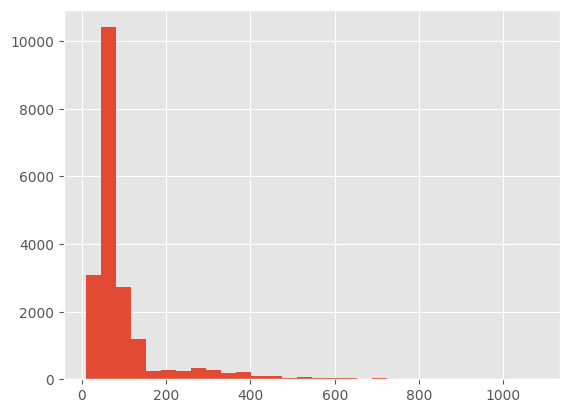

In [166]:
df_energy["Appliances"].hist(bins=30)

In [167]:
df_energy["date"] = pd.to_datetime(df_energy["date"])
df_energy.set_index("date", inplace=True)
df_energy.head()

,Appliances
date,
2016-01-11 17:00:00,60
2016-01-11 17:10:00,60
2016-01-11 17:20:00,50
2016-01-11 17:30:00,50
2016-01-11 17:40:00,60


In [168]:
type(df_energy)

pandas.core.frame.DataFrame

In [169]:
df_energy.columns = ['energy']
df_energy.head()

,energy
date,
2016-01-11 17:00:00,60
2016-01-11 17:10:00,60
2016-01-11 17:20:00,50
2016-01-11 17:30:00,50
2016-01-11 17:40:00,60


In [170]:
df_energy

,energy
date,
2016-01-11 17:00:00,60
2016-01-11 17:10:00,60
2016-01-11 17:20:00,50
2016-01-11 17:30:00,50
2016-01-11 17:40:00,60
...,...
2016-05-27 17:20:00,100
2016-05-27 17:30:00,90
2016-05-27 17:40:00,270


In [171]:
fig = px.line(df_energy, y="energy", title="Energy Consumption")
fig = decorate_plot(fig, ylabel="Energy in wh", xlabel="Date")
fig.show()

In [172]:
df_energy.index.month_name().unique()

Index(['January', 'February', 'March', 'April', 'May'], dtype='object', name='date')

In [173]:
fig = px.line(df_energy.loc["2016-01-11":"2016-01-15",:], y="energy", title="Energy Consumption in January 2016")
fig = decorate_plot(fig, ylabel="Energy in wh", xlabel="Date")
fig.show()

In [174]:
df_energy_hourly = df_energy["energy"].resample("3h").sum()
fig = px.line(df_energy_hourly, y="energy", title="Energy Consumption in January 2016 by day")
fig = decorate_plot(fig, ylabel="Energy in wh", xlabel="Date")
fig.show()

# Step 2: Train / Test set

In [175]:
df_energy_hourly.tail()

date
2016-05-27 06:00:00    1830
2016-05-27 09:00:00    4880
2016-05-27 12:00:00    3310
2016-05-27 15:00:00    2350
2016-05-27 18:00:00     430
Freq: 3h, Name: energy, dtype: int64

In [194]:
train = df_energy_hourly.loc["2016-01-12":"2016-04"]
test = df_energy_hourly.loc["2016-05"]
train.head()

date
2016-01-12 00:00:00    2130
2016-01-12 03:00:00     740
2016-01-12 06:00:00    1100
2016-01-12 09:00:00    1970
2016-01-12 12:00:00    2850
Freq: 3h, Name: energy, dtype: int64

In [195]:
train.tail()

date
2016-04-30 09:00:00    5320
2016-04-30 12:00:00    3620
2016-04-30 15:00:00    4600
2016-04-30 18:00:00    1210
2016-04-30 21:00:00    1110
Freq: 3h, Name: energy, dtype: int64

In [196]:
train.shape

(880,)

In [197]:
test.head()

date
2016-05-01 00:00:00     930
2016-05-01 03:00:00     880
2016-05-01 06:00:00    1180
2016-05-01 09:00:00    1470
2016-05-01 12:00:00    1700
Freq: 3h, Name: energy, dtype: int64

In [198]:
test.tail()

date
2016-05-27 06:00:00    1830
2016-05-27 09:00:00    4880
2016-05-27 12:00:00    3310
2016-05-27 15:00:00    2350
2016-05-27 18:00:00     430
Freq: 3h, Name: energy, dtype: int64

In [199]:
test.shape

(215,)

# Step 3 : Representation Graphique

In [200]:
fig = px.line(train, y="energy", title="Energy Consumption by 3 hours")
fig = decorate_plot(fig, ylabel="Energy in wh", xlabel="Date")
fig.show()

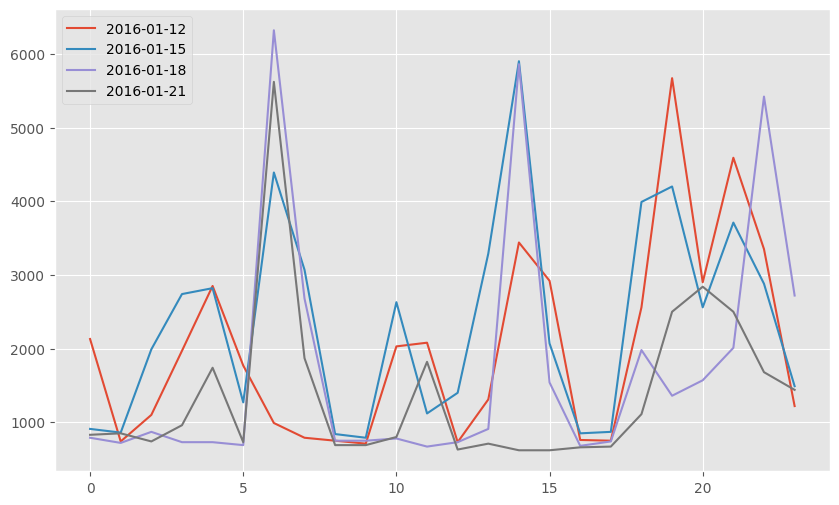

In [201]:
plt.figure(figsize=(10, 6))
m = len(train)
df_new = train["2016-01-12":]
for i in range(0, m//10, 8*3):
    d = df_new.iloc[i:i+8*3].reset_index()

    plt.plot(d["energy"], label=d["date"].iloc[0].strftime("%Y-%m-%d"))
plt.legend()

In [202]:
decomp_result = seasonal_decompose(train, filt=np.repeat(1/50, 50))

In [203]:
decomp_result.seasonal

date
2016-01-12 00:00:00    -838.903347
2016-01-12 03:00:00    -864.429062
2016-01-12 06:00:00    -425.931919
2016-01-12 09:00:00     213.039510
2016-01-12 12:00:00     361.656653
                          ...     
2016-04-30 09:00:00     457.599510
2016-04-30 12:00:00     404.382367
2016-04-30 15:00:00     474.753796
2016-04-30 18:00:00    1233.822367
2016-04-30 21:00:00    -400.352927
Freq: 3h, Name: seasonal, Length: 880, dtype: float64

In [204]:
decomposition_plot(ts_index=train["2016-01-11":"2016-01-20"].index, 
                   observed=decomp_result.observed["2016-01-11":"2016-01-20"], 
                   seasonal=decomp_result.seasonal["2016-01-11":"2016-01-20"], 
                   trend=decomp_result.trend["2016-01-11":"2016-01-20"], 
                   #resid=decomp_result.resid
                   )

In [205]:
stl = STL(train, period=8*3)
decomp_result_slt = stl.fit()

In [188]:
decomposition_plot(ts_index=train.index, 
                   observed=decomp_result_slt.observed, 
                   seasonal=decomp_result_slt.seasonal, 
                   trend=decomp_result_slt.trend, 
                   resid=decomp_result_slt.resid)

# Step 5: Les correlogramme

In [219]:
plot_autocorrelation(train["energy"], nlags=250)

# 

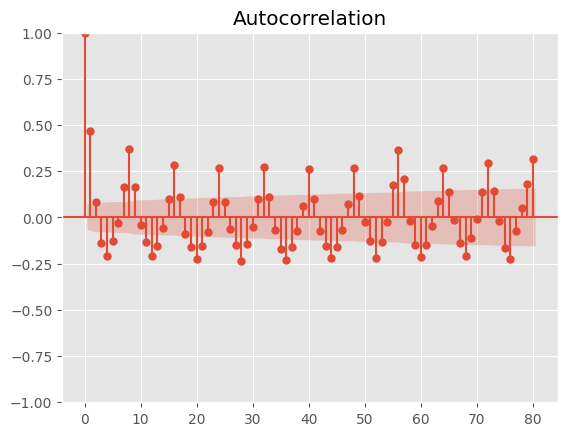

In [228]:
plot_acf(train["energy"], lags=80)
plt.show()

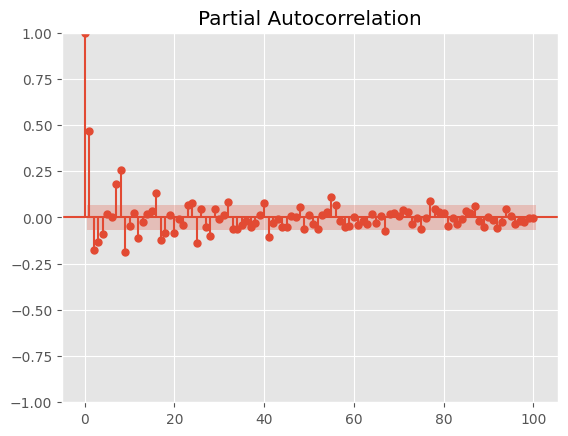

In [230]:
plot_pacf(train["energy"], lags=100)
plt.show()

# Step 6: Methode de Box et Jekins

### 1- Test de stationarité ADF

In [190]:
adf_res = adfuller(train)
adf_res

(-7.249804698705792,
 1.7923863682991228e-10,
 19,
 863,
 {'1%': -3.4379500665211276,
  '5%': -2.864894878219008,
  '10%': -2.5685563904109867},
 14317.547040908745)

In [207]:
ts_ls , inverse_diff = make_stationary(train.to_numpy(), method="diff")
len(ts_ls)


879

In [208]:
ls = [np.nan]
ls.extend(list(ts_ls))
train = train.to_frame()
train["diff"] = ls
train.head()

,energy,diff
date,,
2016-01-12 00:00:00,2130,NaN
2016-01-12 03:00:00,740,-1390.0
2016-01-12 06:00:00,1100,360.0
2016-01-12 09:00:00,1970,870.0
2016-01-12 12:00:00,2850,880.0


In [209]:
train_diff = train.dropna()
train_diff.head()

,energy,diff
date,,
2016-01-12 03:00:00,740,-1390.0
2016-01-12 06:00:00,1100,360.0
2016-01-12 09:00:00,1970,870.0
2016-01-12 12:00:00,2850,880.0
2016-01-12 15:00:00,1770,-1080.0


In [211]:
train_diff["diff"].isin([-np.inf, np.inf]).sum()

0

In [214]:
fig = px.line(train_diff, y="diff", title="Energy diff by 3 hours")
fig = decorate_plot(fig, ylabel="Energy in wh", xlabel="Date")
fig.show()

In [215]:
adf_res = adfuller(train_diff["diff"])
adf_res

(-10.245114088587687,
 4.63948687746789e-18,
 21,
 857,
 {'1%': -3.438003436504483,
  '5%': -2.864918407242872,
  '10%': -2.5685689238190808},
 14278.501628820046)

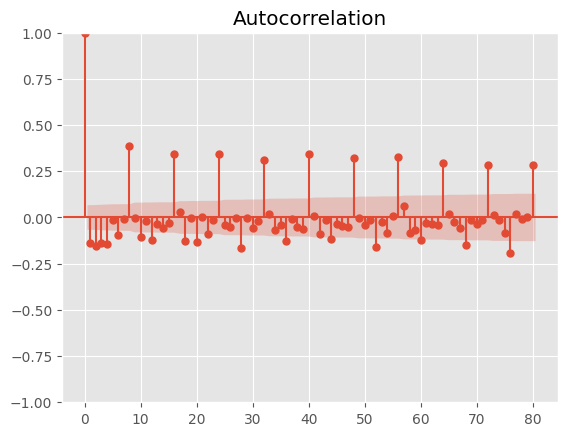

In [ ]:
plot_acf(train_diff["diff"], lags=80 )
plt.show()

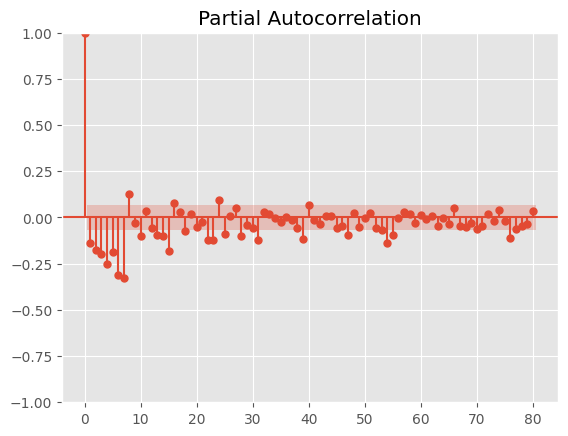

In [226]:
plot_pacf(train_diff["diff"], lags=80)
plt.show()

In [240]:
exp_1 = train_diff["diff"].diff(8)
exp_1.head(20)

date
2016-01-12 03:00:00       NaN
2016-01-12 06:00:00       NaN
2016-01-12 09:00:00       NaN
2016-01-12 12:00:00       NaN
2016-01-12 15:00:00       NaN
2016-01-12 18:00:00       NaN
2016-01-12 21:00:00       NaN
2016-01-13 00:00:00       NaN
2016-01-13 03:00:00    1350.0
2016-01-13 06:00:00     960.0
2016-01-13 09:00:00    -820.0
2016-01-13 12:00:00   -2230.0
2016-01-13 15:00:00    1660.0
2016-01-13 18:00:00    2910.0
2016-01-13 21:00:00    -320.0
2016-01-14 00:00:00   -2120.0
2016-01-14 03:00:00      30.0
2016-01-14 06:00:00     490.0
2016-01-14 09:00:00    3060.0
2016-01-14 12:00:00   -1420.0
Freq: 3h, Name: diff, dtype: float64

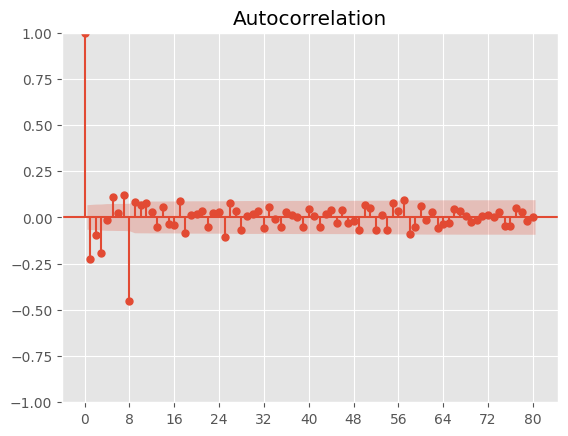

In [245]:
lags = 80
plot_acf(exp_1.dropna(), lags=80)
plt.xticks(np.arange(0, lags+1, 8))
plt.show()

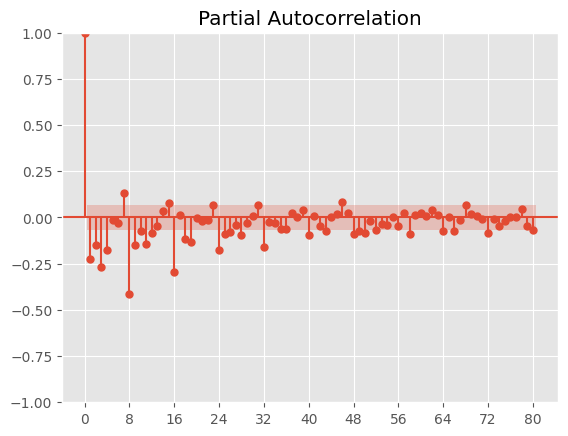

In [252]:
lags = 80
plot_pacf(exp_1.dropna(), lags=lags)
plt.xticks(np.arange(0, lags+1, 8))
plt.show()

In [254]:
model_1 = SARIMAX(train["energy"], order=(5, 1, 1), seasonal_order=(0, 1, 4, 8))
model_1_fit = model_1.fit()
model_1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                       energy   No. Observations:                  880
Model:             SARIMAX(5, 1, 1)x(0, 1, [1, 2, 3, 4], 8)   Log Likelihood               -7189.568
Date:                                      Wed, 25 Dec 2024   AIC                          14401.135
Time:                                              02:09:24   BIC                          14453.601
Sample:                                          01-12-2016   HQIC                         14421.209
                                               - 04-30-2016                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5097      0.027     18.670      0.000       0.456       0.563
ar.L2         -0.0372      0.037     -1.012      0.312      -0.109       0.035
ar.L3         -0.0822      0.045     -1.844      0.065      -0.170       0.005
ar.L4          0.0615      0.052      1.178      0.239      -0.041       0.164
ar.L5          0.0044      0.037      0.118      0.906      -0.069       0.078
ma.L1         -1.0000      0.031    -31.997      0.000      -1.061      -0.939
ma.S.L8       -0.8592      0.029    -29.676      0.000      -0.916      -0.802
ma.S.L16      -0.0913      0.038     -2.409      0.016      -0.166      -0.017
ma.S.L24       0.0183      0.042      0.435      0.664      -0.064       0.101
ma.S.L32      -0.0108      0.031     -0.349      0.727      -0.071       0.050
sigma2       8.41e+05   3.72e-08   2.26e+13      0.000    8.41e+05    8.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               631.20
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             1.10
Prob(H) (two-sided):                  0.37   Kurtosis:                         6.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.18e+28. Standard errors may be unstable.
"""

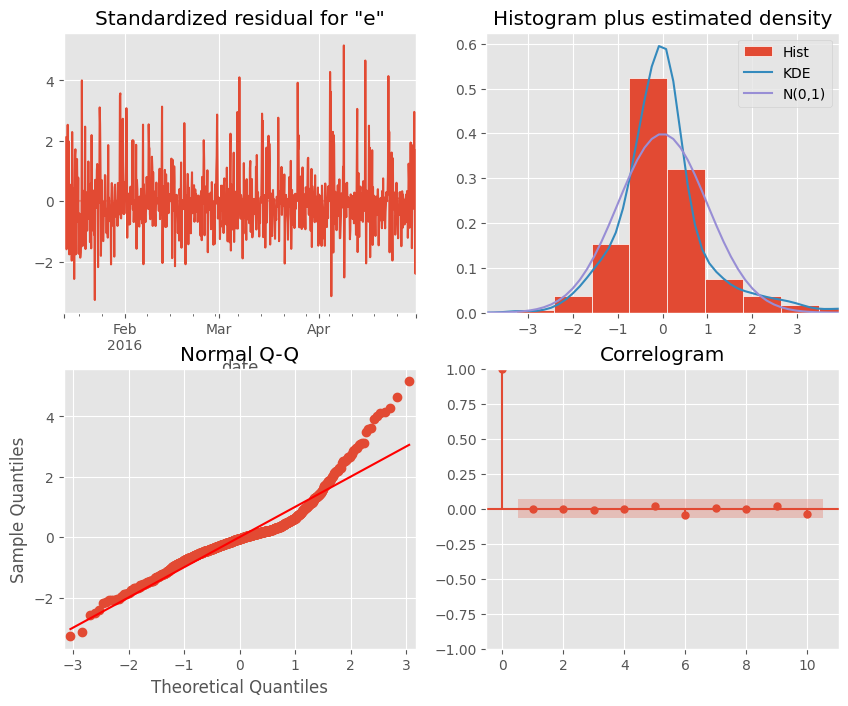

In [256]:
model_1_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [258]:
test.head()

date
2016-05-01 00:00:00     930
2016-05-01 03:00:00     880
2016-05-01 06:00:00    1180
2016-05-01 09:00:00    1470
2016-05-01 12:00:00    1700
Freq: 3h, Name: energy, dtype: int64

In [257]:
test.tail()

date
2016-05-27 06:00:00    1830
2016-05-27 09:00:00    4880
2016-05-27 12:00:00    3310
2016-05-27 15:00:00    2350
2016-05-27 18:00:00     430
Freq: 3h, Name: energy, dtype: int64

In [259]:
pred_1 = model_1_fit.get_prediction(start="2016-05-01 00:00:00", end="2016-05-27 12:00:00")
pred_1_ci = pred_1.conf_int()
pred_1_ci.head()

,lower energy,upper energy
2016-05-01 00:00:00,-902.327941,2695.431940
2016-05-01 03:00:00,-794.543399,3246.270645
2016-05-01 06:00:00,-315.290778,3805.848367
2016-05-01 09:00:00,544.525745,4666.010994
2016-05-01 12:00:00,27.842254,4149.970930


In [264]:
import datetime

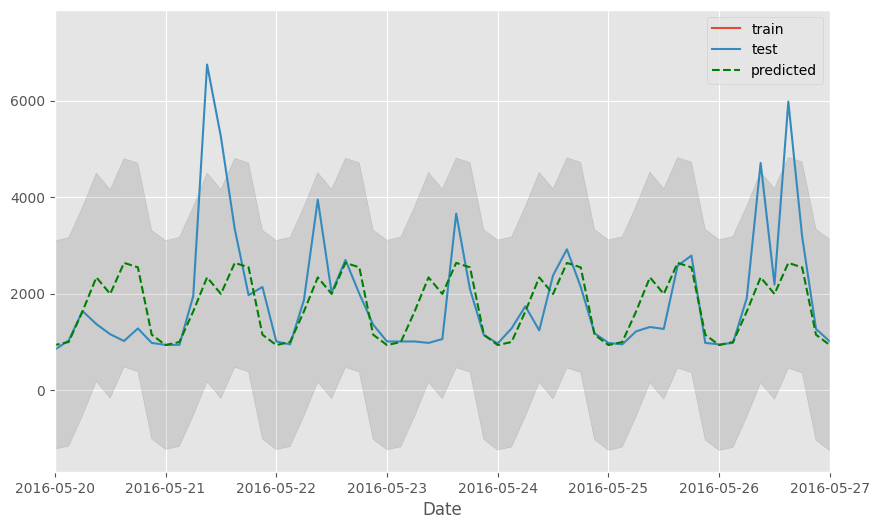

In [267]:
plt.figure(figsize=(10, 6))
plt.plot(train["energy"], label="train")
plt.plot(test, label="test")
plt.plot(pred_1.predicted_mean, label="predicted", linestyle="--", color="green")
plt.fill_between(pred_1_ci.index, pred_1_ci.iloc[:, 0], pred_1_ci.iloc[:, 1], color="k", alpha=0.1)
plt.xlabel("Date")
plt.xlim([datetime.date(2016, 5, 20), datetime.date(2016, 5, 27)])
plt.legend()
plt.show()